In [176]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from oiffile import imread
from PIL import Image
import random
import glob
import torch
import sys
import dognet
#import functions
import skimage
from skimage.transform import resize
import tifffile as tiff

In [ ]:
# load network
device = torch.device("cpu")
net = dognet.SimpleAnisotropic(3,15,36).to(device)
net.weights_init()
netName = "net_bce_1e-%s" %(i)
net = torch.load(netName)

In [ ]:

for i in range(0,len(BRAIN)):

    if i<10:
        n = '000%s' % (i)
    elif i <100:
        n = '00%s' % (i)
    else:
        n = '0%s' % (i)

    fdir = '/Volumes/BACKUP/pcp2cre_syptom_568_mglur1_1to200_647_1to250_vgat_1to200_488_1to250/FV10__20190507_224650_flocculusA/Track%s' % (n)

    im_name = 'Image%s_01.oib' % (n)
    image = imread(os.path.join(fdir,im_name))
    
    finalZImages = []
    
    for z_slice in range(0,16):
    
        # load pre-computed medians of slices
        medianTotal= np.double(np.load("../datasets/flocculusA/medianTotal.npy"))
        
        # normalize, shrink, and cut the image
        image_save = np.double(image[:,z_slice,:,:].transpose(1,2,0))
        image_save[:,:,0] = image_save[:,:,0]/medianTotal[0][z_slice]
        image_save[:,:,1] = image_save[:,:,1]/medianTotal[1][z_slice]
        image_save[:,:,2] = 0
        image_save = resize(image_save,(400,400), order=1, preserve_range=True)

        h=400
        w=400
        tol=30

        UL=(image_save[0:int(h/2+tol),0:int(w/2+tol),:])       
        UR=(image_save[0:int(h/2+tol),int(w/2-tol):w,:])
        LL=(image_save[int(h/2-tol):h,0:int(w/2+tol),:])
        LR=(image_save[int(h/2-tol):h,int(w/2-tol):w,:])

        smallPictures=[UL,UR,LL,LR]
        
        predictedImages=[]
        
        # generate prediction maps
        for j range(0,4):
            imgResized  = resize(smallPictures[j],(115,115), order=1, preserve_range=True)
            img = functions.inference(net,imgResized)
            pMap = resize(img,(460,460), order=1, preserve_range=True)
            predictedImages.append(pMap)
        
        #(x1,y1) as the top-left vertex and (x2,y2) as the bottom-right vertex, im[y1:y2, x1:x2]
        # take mean image of the overlaps and remove edges of overlapping images
        Ntol=60

        top = (predictedImages[0][0:h+Ntol, w-Ntol:w+Ntol, :] + predictedImages[1][0:h+Ntol, 0:2*Ntol, :])/2
        left = (predictedImages[0][h-Ntol:h+Ntol, 0:w+Ntol, :] + predictedImages[2][0:2*Ntol, 0:w+Ntol])/2
        bottom = (predictedImages[2][0:h+Ntol, w-Ntol:w+Ntol, :] + predictedImages[3][0:h+Ntol, 0:2*Ntol, :])/2
        right = (predictedImages[1][h-Ntol:h+Ntol, 0:w+Ntol, :] + predictedImages[3][0:2*Ntol, 0:w+Ntol])/2
        middle = (top[h-Ntol:h+Ntol, 0:2*Ntol, :] + bottom[0:2*Ntol, 0:2*Ntol, :] + right[0:2*Ntol, 0:2*Ntol, :] + left[0:2*Ntol, w-Ntol:w+Ntol, :]/4)
        
                
        topLeft = predictedImages[0][0:h-Ntol, 0:w-Ntol, :]
        topRight = predictedImages[1][0:h-Ntol, 2*Ntol:, :]
        bottomLeft = predictedImages[2][2*Ntol:, 0:w-Ntol, :]
        bottomRight = predictedImages[3][2*Ntol:, 2*Ntol:, :]
        
        #stitch together 4 prediction maps
        finalImage = np.zeros((800,800,3))

        finalImage[:h-Ntol, :w-Ntol, :] = topLeft
        finalImage[:h+Ntol, w-Ntol:w+Ntol] = top
        finalImage[:h-Ntol, w+Ntol:, :] = topRight
        finalImage[h-Ntol:h+Ntol, :w+Ntol, :] = left
        finalImage[h-Ntol:h+Ntol, w-Ntol:, :]=right
        finalImage[h+Ntol:, :w-Ntol, :] = bottomLeft
        finalImage[h-Ntol:, w-Ntol:w+Ntol] = bottom
        finalImage[h+Ntol:, w+Ntol:, :] = bottomRight
        #finalImage[h-Ntol:h+Ntol, w-Ntol:w+Ntol, :]= middle
        
        # save all final images in z stack
        finalZImages.append(finalImage)
    
    stack = np.stack(finalZImages, axis=0))
    
            

In [168]:
image = Image.open("/Users/morganneuwirth/Desktop/download.jpg")
img = np.array(image)
image_save = resize(img,(400,400), order=1, preserve_range=True)

h=400
w=400
tol=30

UL=(image_save[0:int(h/2+tol),0:int(w/2+tol),:])       
UR=(image_save[0:int(h/2+tol),int(w/2-tol):w,:])
LL=(image_save[int(h/2-tol):h,0:int(w/2+tol),:])
LR=(image_save[int(h/2-tol):h,int(w/2-tol):w,:])

UL = resize(UL,(460,460), order=1, preserve_range=True)
UR = resize(UR,(460,460), order=1, preserve_range=True)
LL = resize(LL,(460,460), order=1, preserve_range=True)
LR = resize(LR,(460,460), order=1, preserve_range=True)

predictedImages=[UL,UR,LL,LR]

In [169]:
h=400
w=400
Ntol=60

top = (predictedImages[0][0:h+Ntol, w-Ntol:w+Ntol, :] + predictedImages[1][0:h+Ntol, 0:2*Ntol, :])/2
left = (predictedImages[0][h-Ntol:h+Ntol, 0:w+Ntol, :] + predictedImages[2][0:2*Ntol, 0:w+Ntol])/2
bottom = (predictedImages[2][0:h+Ntol, w-Ntol:w+Ntol, :] + predictedImages[3][0:h+Ntol, 0:2*Ntol, :])/2
right = (predictedImages[1][h-Ntol:h+Ntol, 0:w+Ntol, :] + predictedImages[3][0:2*Ntol, 0:w+Ntol])/2
middle = (top[h-Ntol:h+Ntol, 0:2*Ntol, :] + bottom[0:2*Ntol, 0:2*Ntol, :] + right[0:2*Ntol, 0:2*Ntol, :] + left[0:2*Ntol, w-Ntol:w+Ntol, :]/4)

topLeft = predictedImages[0][0:h-Ntol, 0:w-Ntol, :]
topRight = predictedImages[1][0:h-Ntol, 2*Ntol:, :]
bottomLeft = predictedImages[2][2*Ntol:, 0:w-Ntol, :]
bottomRight = predictedImages[3][2*Ntol:, 2*Ntol:, :]

In [174]:
finalImage = np.zeros((800,800,3))

finalImage[:h-Ntol, :w-Ntol, :] = topLeft
finalImage[:h+Ntol, w-Ntol:w+Ntol] = top
finalImage[:h-Ntol, w+Ntol:, :] = topRight
finalImage[h-Ntol:h+Ntol, :w+Ntol, :] = left
finalImage[h-Ntol:h+Ntol, w-Ntol:, :]=right
finalImage[h+Ntol:, :w-Ntol, :] = bottomLeft
finalImage[h-Ntol:, w-Ntol:w+Ntol] = bottom
finalImage[h+Ntol:, w+Ntol:, :] = bottomRight

#finalImage[h-Ntol:h+Ntol, w-Ntol:w+Ntol, :]= middle

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


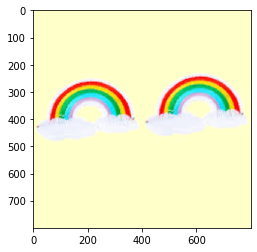

In [175]:
plt.imshow(finalImage/250)